In [1]:
import os, sys, time, glob, random
# load yaml config
import yaml
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

from fit import lr_schedule, fit, TrainState, load_ckpt
# from model.unetv3_light import UNetV3 as UNet
from demo.unetv3_light import UNetV3 as UNet
# cpu mode
jax.config.update('jax_platform_name', 'cpu')


key = jax.random.PRNGKey(0)
cfg = yaml.safe_load(open("config.yaml"))
print(cfg)

# predict one image
def predict_one_image(state, img_path, cfg):
    # get ratio of the image
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    bg_h, bg_w = cfg['img_size']

    # resize the raw image to fit the bg_w
    # resize the image to fit the bg_w
    ratio = bg_w / w
    img = img.resize((bg_w, int(h * ratio)))
    
    # paste the image to the top-left corner of the black background
    bg_black = Image.new('RGB', (bg_w, bg_h), (0, 0, 0))
    bg_black.paste(img, (0, 0))
    img = bg_black

    # show this image via plt
    plt.imshow(img)
    plt.show()

    img = jnp.array(img)
    img = jnp.expand_dims(img, axis=0) / 255.
    pred = state.apply_fn({
        'params': state.params,
        'batch_stats': state.batch_stats,
    }, img, mutable=['batch_stats'], rngs={'dropout': key})
    return pred


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

{'img_size': [256, 256], 'features': 16, 'batch_size': 8, 'lr': 0.003, 'epochs': 100, 'warmup': 5, 'focal_loss': {'weight': 1.0}, 'dice_bce_loss': {'weight': 1.0}}


W0000 00:00:1722074183.826232 17410329 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1722074183.848512 17410329 service.cc:145] XLA service 0x352753910 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722074183.848665 17410329 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1722074183.850736 17410329 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1722074183.850881 17410329 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [2]:
model = UNet(cfg["features"], training=False)
var = model.init(key, jnp.zeros((1, *cfg["img_size"], 3)))
params = var['params']
batch_stats = var['batch_stats']

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=optax.inject_hyperparams(optax.nadam)(0),
)

==         Loading ckpt from demo/checkpoint_100          ==


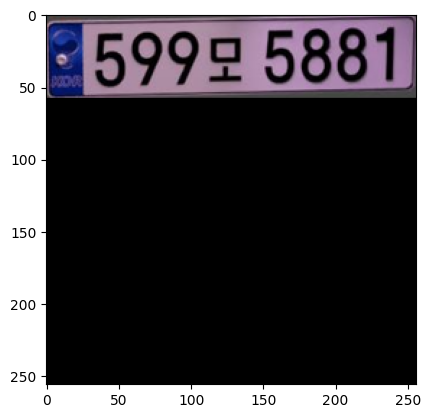

In [3]:
# single test for load via given folder path
# ckpt_path = 'checkpoints'
ckpt_path = 'demo/checkpoint_100'
state = load_ckpt(state, ckpt_path)

# predict one image
img_path = '/Users/haoyu/Documents/datasets/lpr/val/*.jpg'
# img_path = "debug/*.jpg"

img_path = random.choice(glob.glob(img_path))
(pixs), _ = predict_one_image(state, img_path, cfg)

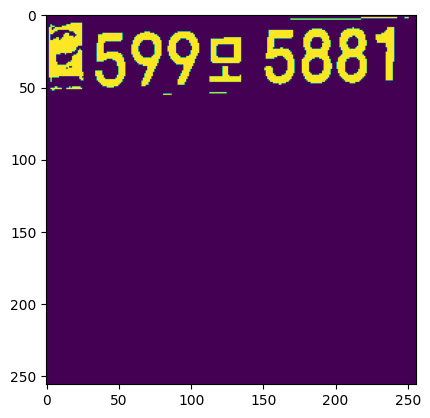

In [4]:
from matplotlib import pyplot as plt

pixs = jax.nn.sigmoid(pixs)
pixs = jnp.where(pixs > 0.5, 1, 0)
plt.imshow(pixs[0])
plt.show()


In [5]:
# show ord_
ord_ = jnp.where(ord_[0] > 0.1, 1, 0)
ord_ = jnp.argmax(ord_, axis=-1)
plt.imshow(ord_)
plt.show()

n = 10
scale = 2
fig, ax = plt.subplots(1, n, figsize=(n*scale, scale))
for i in range(n):
    tmp = debug_ord[0, :, :, i]
    tmp = jnp.where(tmp > 0.1, 1, 0)
    ax[i].imshow(tmp)
    ax[i].axis('off')

plt.show()


NameError: name 'ord_' is not defined

In [ ]:
ord_ = jnp.where(ord_ > 0.5, ord_, 0)
ord_ += 1
res = ord_ * np.squeeze(pixs)

# show original image and predicted result
img = Image.open(img_path).convert("RGB")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(res)
plt.show()